# 7 years on, revisiting the demands of the Tunisian and Egyptian springs

[S. Moraes Sarmento](mailto:simao.moraessarmento@epfl.ch), [K. Mrini](mailto:khalil.mrini@epfl.ch), [K. Omari](mailto:khalid.omari@epfl.ch)

## Table of Contents

### [1. Selecting Keyphrases to Filter Text Data](#1)

- [1.1. Tokenization and Filtering based on Parts of Speech](#11)

- [1.2. Forming N-Grams](#12)

- [1.3. Downloading Wikipedia Articles](#13)

- [1.4. Extracting Most Popular Tokens](#14)

- [1.5. Extracting Keyphrases from Wikipedia Articles](#15)

- [1.6. Examples of Keyphrases](#16)

- [1.7. Comparing Texts to Keyphrases](#17)

### [2. Sampling and Filtering the 2.1 TB of Compressed Data](#2)
- [2.1. Reading a Single .protostream File](#21)

- [2.2. Reading the Compressed .tar.gz Files to Pandas DataFrame](#22)

- [2.3. Loading the DataFrame](#23)

- [2.4. Data Cleaning](#24)

- [2.5. Data Analysis: Language and Post Type Distributions](#25)

- [2.6. How different are Jan. 14 and Feb. 11 in Data Distributions?](#26)
    - [2.6.1. Language and Post Type Distributions](#261)
    - [2.6.2. Country Distributions](#262)

- [2.7. Keyword Detection by Language and Post Type](#27)
    - [2.7.1. Keyword Extraction](#271)
    - [2.7.2. Keywords on January 14](#272)
    - [2.7.3. Keywords on February 11](#273)
    
### [3. Future Directions](#3)

# 1. Selecting Keyphrases to Filter Text Data<a class="anchor" id="1"></a>

**Problem**

Having seen the data, we noticed that large parts of it were not related to the Arab Spring revolutions of 2011. Spinn3r, the company providing the data, is actually promoting their scraping API by doing so.

Therefore, we must find keyphrases to filter this data based on the Tunisian and Egyptian revolutions.

**Solution Proposed**

Using **Wikipedia** articles for the Tunisian and Egyptian revolutions, we ***automatically*** extract the keyphrase that will be used for filtering. Given that the data is provided in various languages, we choose to focus on three relevant languages: **English**, **French**, and **Arabic**.

**Added Value**

In comparison with the only paper participating in the 2011 ICWSM Spinn3r Challenge, <a href='http://www.icwsm.org/2011/documents/IDC2011.pdf'>*Revolution 2.0 in Tunisia and Egypt: Reactions and Sentiments in the Online World*</a>:
1. We use **keyphrases** instead of **keywords**, by using n-grams;
2. We do not choose keyphrases manually, but extract them from Wikipedia automatically;
3. We provide insight by evaluating data not only in English, but in two additional languages: French, Tunisia's colonial-era and second most popular language, and Arabic, the native language of both the peoples of Tunisia and Egypt.

**In the following:** we first establish helper functions before compiling it in one function to get the keyphrases for each language, and each country.

## 1.1. Tokenization and Filtering based on Parts of Speech<a class="anchor" id="11"></a>

The following are the languages that we focus on throughout the project:

In [4]:
EN = 'english'
FR = 'french'
AR = 'arabic'
LANGS = [EN, FR, AR]

We use a *Regular Expression Tokenizer* with the *NLTK* (Natural Language Toolkit) package for the textual data.

We want our keyphrases to contain **interesting words**, and therefore we eliminate stop words using the corresponding corpus from NLTK, and we eliminate verbs and adverbs using the **state-of-the-art Stanford POS Tagger**. We have to check the distinct *tag sets* of each language's POS tagger for filtering.

In [5]:
# NLTK Imports
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tag import StanfordPOSTagger

# Setting up POS Tagger and Stop Word Lists
TOKENIZER = RegexpTokenizer(r'\w+')
STOPWORDS = dict((language, set(stopwords.words(language))) for language in LANGS)

# Setting up POS Taggers
STANFORD_PREFIX = './Stanford POS Taggers/'
JAR = 'stanford-postagger.jar'
POS_TAGGERS = dict((language, 
                    StanfordPOSTagger(STANFORD_PREFIX + language + '.tagger', 
                                      STANFORD_PREFIX + JAR)) 
                   for language in LANGS)

# Tags of Adverbs and Verbs in each language's POS Tagger
REFUSED_POS_TAGS = {EN: ['V', 'R', 'MD', 'IN', 'CD'], 
                    FR: ['ADV', 'D', 'PREF', 'V'],
                    AR: ['V']}

def tag_is_allowed(tag, language):
    """
    Determines if given tag is not a verb or adverb using REFUSED_POS_TAGS.
    :param tag: string, tag of a word as determined by POS Tagger
    :param language: string
    :return: Boolean, True if tag should be kept
    """
    for other_tag in REFUSED_POS_TAGS[language]:
        if tag.startswith(other_tag):
            return False
    return True

def tokenize_without_stopwords(text, language):
    """
    Removes stop words and digit-only tokens.
    :param text: string
    :param language: string
    :return: list of strings
    """
    tokens = [token for token in TOKENIZER.tokenize(text.lower()) 
              if token not in STOPWORDS[language] 
              and not token.isdigit()]
    return tokens

def preprocess_for_keyphrases(text, language):
    """
    Tokenizes, removes stopwords and digit-only tokens, removes verbs and adverbs.
    :param text: string
    :param language: string, language of text
    :return: list of strings, tokens of text
    """
    # Removing stop words, digit-only tokens
    tokens = tokenize_without_stopwords(text, language)
    # POS-Tagging
    tokens_with_tags = POS_TAGGERS[language].tag(tokens)
    # Handling the case of the Arabic POS Tagger, as it concatenates token and POS tag
    if language == AR:
        tokens_with_tags = [tag[1].split('/') for tag in tokens_with_tags]
    # POS-Tag filtering
    tokens = [token for token, tag in tokens_with_tags 
              if tag_is_allowed(tag, language)]
    return tokens

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning:


The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning:


The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning:


The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.



## 1.2. Forming N-Grams<a class="anchor" id="12"></a>

Having formed tokens, we want now to give sense to keyphrases by forming n-grams. We use NLTK for that as well. We use the regular expression package to have the newly-formed n-grams as one token.

In [6]:
# NLTK and regexp Imports
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import re

def form_n_grams(tokens, threshold):
    """
    Forms tokens that are n-grams with a minimum frequency threshold.
    :param tokens: list of strings
    :param threshold: int
    :return: list of strings, n-gram'd tokens
    """
    # Bigram Finder
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(threshold)
    # Bigrams
    scored_bigrams = finder.score_ngrams(BigramAssocMeasures.raw_freq)
    # Joining Bigrams in the text
    text = ' '.join(tokens)
    for (word1, word2), score in scored_bigrams:
        text = re.sub(r'\b{}\b \b{}\b'.format(word1, word2), '{}_{}'.format(word1, word2), text)
    tokens = text.split(' ')
    return tokens

We form n-grams over different rounds, each round incrementing the *n* parameter.

Given that Arabic is more agglutinative than English and French, it gets less rounds. The following are the rounds that we define to form n-grams:

In [7]:
NGRAM_RANGE = {EN: range(3), 
               FR: range(3), 
               AR: range(1,3)}

The following function forms the n-grams over rounds. To keep interesting tokens, we remove tokens that have less than 4 characters. We remove these tokens only after forming n-grams because we noticed that short unigrams can form interesting n-grams.

In [8]:
MIN_CHAR_COUNT = 4

def n_gram_rounds(tokens, language, threshold):
    """
    Forms n-grams over rounds given unigram tokens.
    :param tokens: list of strings
    :param language: string
    :param threshold: int
    :return: list of strings, n-gram tokens
    """
    for ngram_round in NGRAM_RANGE[language]:
        tokens = form_n_grams(tokens, threshold + ngram_round)
    tokens = [token for token in tokens if len(token) >= MIN_CHAR_COUNT]
    return tokens

## 1.3. Downloading Wikipedia Articles<a class="anchor" id="13"></a>

Throughout the project, we focus on the two following countries:

In [9]:
EG = 'Egypt'
TN = 'Tunisia'

We use the following articles to extract keyphrases.

In [10]:
WIKI_ARTICLES = {TN: {EN: 'Tunisian Revolution', 
                      FR: 'Révolution tunisienne', 
                      AR: 'الثورة التونسية'},
                 EG: {EN: 'Egyptian Revolution', 
                      FR: 'Révolution égyptienne de 2011', 
                      AR: 'ثورة 25 يناير'}}

We use the *Wikipedia* Python package to extract article content.

In [11]:
# Wikipedia import
import wikipedia

def download_wikipedia_article(wiki_article, language):
    """
    Downloads the text content of a given Wikipedia article in a given language.
    :param wiki_article: string, title of article
    :param language: string
    :return: string
    """
    wikipedia.set_lang(language[:2])
    wiki = wikipedia.page(wiki_article)
    return wiki.content

## 1.4. Extracting Most Popular Tokens<a class="anchor" id="14"></a>

Once we have formed phrases and have them as a list of strings, we use `Counter` to get the most popular phrases.

In [12]:
from collections import Counter

def get_most_popular_tokens(tokens, num_keyphrases):
    """
    Gets most popular num_keywords elements of tokens.
    :param tokens: list of strings
    :param num_keyphrases: int
    :return: list of strings
    """
    counter = Counter(tokens)
    keyphrases = [word.replace('_', ' ') for word, score in counter.most_common(num_keyphrases)]
    return keyphrases

## 1.5. Extracting Keyphrases from Wikipedia Articles<a class="anchor" id="15"></a>

We concatenate all of the above in the following function:

In [13]:
def get_wikipedia_keyphrases(wiki_article, language, num_keyphrases=50, threshold=1):
    """
    Gets Keyphrases from Wikipedia Article.
    :param wiki_article: string, name of Wikipedia Article
    :param language: string
    :param num_keyphrases: int, number of keyphrases to extract
    :param threshold: int, n-gram formation threshold
    :return: list of strings, keyphrases
    """
    wiki_content = download_wikipedia_article(wiki_article, language)
    unigram_tokens = preprocess_for_keyphrases(wiki_content, language)
    ngram_tokens = n_gram_rounds(unigram_tokens, language, threshold)
    keyphrases = get_most_popular_tokens(ngram_tokens, num_keyphrases)
    return keyphrases

We extract 50 keyphrases, per country, and per language:

In [13]:
keyphrase_dict = dict((country, 
                       dict((language, get_wikipedia_keyphrases(WIKI_ARTICLES[country][language], language)) 
                            for language in WIKI_ARTICLES[country])) 
                      for country in WIKI_ARTICLES)

KeyboardInterrupt: 

We save these keywords in the `Keyphrases` folder:

In [14]:
for country in keyphrase_dict:
    for language in keyphrase_dict[country]:
        keyphrase_file = open('./Keyphrases/{}_{}.txt'.format(country, language), 'w')
        print('\n'.join(keyphrase_dict[country][language]), file=keyphrase_file)
        keyphrase_file.close()

NameError: name 'keyphrase_dict' is not defined

## 1.6. Examples of Keyphrases<a class="anchor" id="16"></a>

In the following, we provide an example of keyphrases for English in **Tunisia**. The most popular is `ben ali`, the last name of Tunisia's ousted president. The phrase `sidi bouzid` designates the city where protests started in January 2011.

In [15]:
keyphrase_dict[TN][EN][:10]

NameError: name 'keyphrase_dict' is not defined

Hereafter is an sample of keyphrases for English in **Egypt**. The most popular one is `tahrir square`, a public square in the Egyptian capital, Cairo, where the protesters camped throughout the protests. The `muslim brotherhood` is the opposition party that later came into power. Here, the Egyptian ousted president's full name, `hosni mubarak`, comes up as one of the keyphrases.

In [12]:
keyphrase_dict[EG][EN][:10]

NameError: name 'keyphrase_dict' is not defined

## 1.7. Comparing Texts to Keyphrases<a class="anchor" id="17"></a>

Given these keyphrases, we want to estimate how many of those appear in a given text:

In [14]:
def keyphrase_score(country, language, text):
    """
    Computes how many keyphrases for the country and language are in the text.
    :param country: string
    :param language: string
    :param text: string
    :return: int
    """
    score = 0
    for keyphrase in keyphrase_dict[country][language]:
        if keyphrase in text:
            score += 1
    return score

We use this function to compute the keyphrase scores per country and for a given language and a given text:

In [15]:
def compute_keyphrase_scores(text, language):
    """
    Computes keyphrase scores for all countries given text and language.
    Returns False if all scores are inferior to 4.
    :param text: string
    :param language: string
    :return: dict or boolean
    """
    new_text = text.lower()
    data = {}
    score_sum = 0
    for country in keyphrase_dict:
        score = keyphrase_score(country, language, new_text)
        data[country] = score
        score_sum += score
    if score_sum <= 4:
        return False
    else:
        return data

# 2. Sampling and Filtering the 2.1 TB of Compressed Data<a class="anchor" id="2"></a>

**Steps to Reach Text Data**

The files are compressed in `.tar.gz` format. The steps to reach text data are more complex than we thought:
1. We downloaded a sample, and the decompressed files are in `.protostream` format. This format **lacks documentation**. A `.protostream` file is a stream of Google's `protobuf` format.
2. The `.protostream` format requires `.proto` files to extract them. We found these files on the internet, not on Spinn3r's website. This format was originally made for Java, and has difficult compatibility with Python.
3. We installed the C++ `protoc` library to make `.py` files out of `.proto` files. These `.py` files contain Python classes that we can use to read the data. The `.proto` and `.py` files can be found on our GitHub repo.
4. We found the code to read the text data on a *Stackoverflow* answer rated `-1`, rather than on Spinn3r's website or the `protobuf` documentation.

**Sample Evaluated**

We downloaded compressed samples of about **40 GB** for the days of **January 14, 2011** and **February 11, 2011**, respectively the days of the resignation of the presidents of Tunisia and Egypt.

**In the following:** we first read the data and filter it based on the keywords found in the first section.

## 2.1. Reading a Single `.protostream` File <a class="anchor" id="21"></a>

We first import the `.py` files that we got out of the `.proto` files. The `spinn3rApi_pb2.py` file contains the classes needed to parse the bytes of a given internet entry. The `protoStream_pb2.py` file contains the classes needed to separate entries inside a `.protostream` file, most notably the `ProtoStreamDelimiter` class.

In [13]:
import proto.spinn3rApi_pb2 as proto_api
import proto.protoStream_pb2 as proto_stream

DELIMITER = proto_stream.ProtoStreamDelimiter()

ImportError: No module named 'google'

We will need the following decoder to separate entries in a `.protostream` file.

In [19]:
from google.protobuf.internal.decoder import _DecodeVarint32

# length, pos = decoder(file, pos) => pos is starting point, length is the length of the record in file
DECODER = _DecodeVarint32

ImportError: No module named 'google'

In the files we find, we find the languages as two-letter language codes. We will need a mapping to full-length name:

In [16]:
CODE_TO_LANG = dict((language[:2], language) for language in LANGS)

We use the following functions to read a single `.protostream` file onto a list of `dict` instances. We use `BeautifulSoup` for some `html` data, that is itself `zlib`-encoded.

In [17]:
import zlib
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

def try_to_get_content(entry):
    """
    Attempts to get content from an entry.
    :param entry: contentApi.Entry
    :return: string
    """
    try:
        return BeautifulSoup(zlib.decompress(entry.feed_entry.content.data), "html.parser").text
    except:
        return ""

def read_protostream_file(file):
    """
    Reads a single .protostream file.
    :param file: bytes
    :return: list of dictionaries
    """
    data_rows = []
    
    length, pos = DECODER(file, 0)
    pos += length

    while pos < len(file):
        length, pos = DECODER(file, pos)
        DELIMITER.ParseFromString(file[pos:pos + length])
        if DELIMITER.delimiter_type == DELIMITER.END:
            break
            
        # This means we found an Entry
        elif DELIMITER.delimiter_type == DELIMITER.ENTRY:
            pos += length
            length, pos = DECODER(file, pos)
            
            # The Entry Class enables to read the contents of the record
            entry = proto_api.Entry()
            entry.ParseFromString(file[pos:pos + length])
            
            lang_code = entry.feed_entry.lang[0].code
            
            # Proceeding if the language is English, French or Arabic
            if lang_code in CODE_TO_LANG:
                post_title = entry.feed_entry.title
                post_content = try_to_get_content(entry)
                data = compute_keyphrase_scores(post_title + ' ' + post_content, 
                                                CODE_TO_LANG[lang_code])
                if data:
                    # Language Code
                    data['Lang_Code'] = lang_code
                    
                    # Post Title
                    data['Post_Title'] = post_title
                    
                    # Post Content
                    if post_content:
                        data['Post_Content'] = post_content
                    
                    # Language Probability
                    try:
                        data['Lang_Prob'] = entry.feed_entry.lang[0].probability
                    except:
                        pass

                    # Link
                    try:
                        data['Post_Link'] = entry.feed_entry.link[0].href
                    except:
                        pass

                    # Author Name
                    try:
                        data['Author_Name'] = entry.feed_entry.author[0].name
                    except:
                        pass

                    # Author Link
                    try:
                        data['Author_Link'] = entry.feed_entry.author[0].link[0].href
                    except:
                        pass

                    # Date & Time
                    try:
                        data['Datetime'] = entry.feed_entry.last_published
                    except:
                        pass

                    # Identifier
                    try:
                        data['Identifier'] = entry.feed_entry.identifier
                    except:
                        pass

                    # Spam Probability
                    try:
                        data['Spam'] = entry.feed_entry.spam_probability
                    except:
                        pass

                    # Publisher Type
                    try:
                        data['Type'] = entry.source.publisher_type
                    except:
                        pass

                    # Category
                    try:
                        data['Category'] = entry.feed_entry.category
                    except:
                        pass

                    data_rows.append(data)
        pos += length
    return data_rows

## 2.2. Reading the Compressed `.tar.gz` Files to Pandas `DataFrame`<a class="anchor" id="22"></a>

We downloaded the files in an external harddrive. We set up the following variables:

In [18]:
TAR_PREFIX = '/Users/simaomoraessarmento/Desktop/'
JSON_PREFIX = './Text Data/'
FILES = '01-14-OTHER 01-14-SOCIAL_MEDIA 02-11-OTHER 02-11-SOCIAL_MEDIA'.split(' ')
TAR = '.tar.gz'
JSON = '.json'

To read a `.tar.gz` file without decompressing it, we use the following package:

In [19]:
import tarfile

We save the files to Pandas `DataFrame`.

In [20]:
import pandas as pd

In the following we read the `.tar.gz` files and save them to `.json` files as Pandas `DataFrame`:

In [25]:
for file_name in FILES:
    data_rows = []
    
    # Reading the .tar.gz file
    tar = tarfile.open(TAR_PREFIX + file_name + TAR, "r:gz")
    print("content: ", tar)
    
    # Members are the components (files, folders...) found inside the compressed file
    members = tar.getmembers()
    member_count = len(members)
    
    # Reading each individual file
    for member_index in range(member_count):
        file_data = tar.extractfile(members[member_index])
        if file_data is not None:
            content = file_data.read()
            data_rows.extend(read_protostream_file(content))
    
    # Compiling as Pandas DataFrame, then saving to json files
    df = pd.DataFrame(data_rows)
    df.to_json('{}{}.json'.format(JSON_PREFIX, file_name))
    

NameError: name 'tarfile' is not defined

## 2.3. Loading the `DataFrame`:<a class="anchor" id="23"></a>

In the following we will need `numpy`:

In [21]:
import numpy as np

We define the following functions to load the files from each date into the corresponding `DataFrame`:

In [22]:
def load_df():
    """
    Loads the files into dataframes per date
    :return: DataFrame
    """
    df = pd.DataFrame()
    for file in FILES:
        file_df = pd.read_json(JSON_PREFIX + file + '.json')
        file_df['Month'] = file_df.Datetime.apply(lambda row: get_month(row, int(file[:2])))
        df = df.append(file_df, ignore_index=True)
    return df

def get_month(row, default_month):
    """
    Returns the corresponding month or default_month if Nan
    :param row:  
    """
    if not np.isnan(row.month):
        return row.month
    else:
        return default_month

We can get a quick glance at the `DataFrame` with the most relevant posts:

In [23]:
df = load_df()
df.sort_values([EG, TN], ascending=False).head()

,Author_Link,Author_Name,Category,Datetime,Egypt,Identifier,Lang_Code,Lang_Prob,Post_Content,Post_Link,Post_Title,Spam,Tunisia,Type,Month
22669,,Lara Friedman,{},2011-02-11 20:47:03,26,1297460101090980356,en,-1,\n======================= APN Legislative Roun...,http://peacenow.org/entries/legislative_round-...,Legislative Round-Up: Week Ending 2/11/11,0,15,MAINSTREAM_NEWS,2
34615,,الشاعلر,{},2011-02-11 19:54:35,25,1297459865090980374,ar,-1,\nجلة التايم الأمريكية تضع الرئيس صالح في المر...,http://forum.sh3bwah.maktoob.com/showthread.ph...,ثورتي تونس ومصر بثت الخوف في قلب صالح فسارع إل...,0,33,FORUM,2
35871,,الشاعلر,{},2011-02-11 19:54:35,25,1297456634081625128,ar,-1,\nجلة التايم الأمريكية تضع الرئيس صالح في المر...,http://forum.sh3bwah.maktoob.com/showthread.ph...,ثورتي تونس ومصر بثت الخوف في قلب صالح فسارع إل...,0,33,FORUM,2
43560,,,{},2011-02-11 21:01:00,25,1297461312090849299,en,-1,Key events during Egypt's uprising:- Jan. 25 -...,http://www.star-telegram.com/2011/02/11/284216...,A look at how Egypt's uprising unfolded,0,18,MAINSTREAM_NEWS,2
41135,,ahaha,{},2011-02-11 19:05:24,24,1297451451119193629,ar,-1,مساعد وزير الداخلية :ثروة العادلي 17 مليار و 2...,http://www.egyptsons.com/misr/showthread.php?t...,مساعد وزير الداخلية :ثروة العادلي 17 مليار و 2...,0,13,FORUM,2


## 2.4. Data Cleaning<a class="anchor" id="24"></a>

In this section, we aim to **clean** our df by **deleting meaningless information**. We start by checking the columns of the df:

In [24]:
df.columns

Index(['Author_Link', 'Author_Name', 'Category', 'Datetime', 'Egypt',
       'Identifier', 'Lang_Code', 'Lang_Prob', 'Post_Content', 'Post_Link',
       'Post_Title', 'Spam', 'Tunisia', 'Type', 'Month'],
      dtype='object')

By observing the displayed Data Drame above, we quickly infer that features such as: `Lang_Prob`, `Spam`  and `Category` seem to add no meaning. In fact, information about category is already accessible in `Type`. Moreover, we verify, for the two remaining meaningless features, that they display a constant value:

In [25]:
#Verify values for meaningless columns
print(df.Lang_Prob.unique())
print(df.Spam.unique())

[-1]
[0]


We drop the features hereafter:

In [26]:
#clean meaningless features
df = df.drop(['Lang_Prob', 'Spam'], axis = 1)

**Moreover**, we verify some **redundacy** in our df, since **the content of several entries is repeated**. Therefore, we deal with such repetitions:

In [27]:
#delete repetitions
for feature in ['Identifier', 'Post_Content']:
    df.drop_duplicates(feature, keep='first', inplace=True) 

Let's verify that the values are now unique:

In [28]:
print(len(df.Identifier.unique()) == len(df), len(df.Post_Content.unique()) == len(df))

True True


Finally, the df **is cleaned**. 

We follow on with a **description of the `DataFrame` features**:

- `Author_Link` - Contains a link to the author profile, in case of a Facebook Post, or his email adress. This information however is not always available.
- `Author_Name` - Contains the name of the author  
- `Datetime` - Represents the Date and Time of a post, in a TimeStamp format
- `Egypt` -  Represents the number of defined **keyphrases** (egyptian) in the post.
- `Identifier`- Each post as an unique identifier
- `Lang_Code` - Code of the language of the corresponding post
- `Post_Content` - Content of the post
- `Post_Link`- Link to the source of the post
- `Post_Title`- Title of the post
- `Tunisia`- Represents the number of defined **keyphrases** (tunisian) in the post.
- `Type` - Type of post. Categorical feature that can take the following values: [`CLASSIFIED`, `FORUM`, `MAINSTREAM_NEWS`, `SOCIAL_MEDIA`]

## 2.5. Data Analysis: Language and Post Type Distributions<a class="anchor" id="25"></a>

Having **cleaned** our data, we move on with the **analysis** of the collected information. We define thw following functions to analyse the resulting Dataframe:

In [29]:
import random
import matplotlib.pyplot as plt

plt.rcParams['text.color'] = 'k'
plt.rcParams['font.size'] = 12

def plot_pie_chart(pandas_object, show=False):
    """
    plots porportions as a pie chart given:
    :param pandas_object: Pandas Series or DF to plot
    :param show: boolean
    """
    # define labels and corresponding proportion
    try:
        labels = sorted(pandas_object.unique())
    except:
        labels = pandas_object.unique()
    proportions = [len(pandas_object[pandas_object == label])/len(pandas_object) for label in labels]
    
    # define a color map
    cmap = plt.get_cmap('Spectral')
    colors = cmap(np.linspace(0, 1, len(labels)))
    
    # explode 1st slice
    explode = [0 if proportion > .3 else .1 for proportion in proportions]
    
    plt.title('Proportion of items by {}'.format(pandas_object.name))
    plt.pie(proportions, explode=explode, labels=None, colors=colors[:len(proportions)],
        autopct='%1.1f%%', shadow=True, startangle=140, pctdistance=1.2)
    plt.legend(labels=labels, bbox_to_anchor=(1, 1))
    plt.axis('equal')
    if show:
        plt.show()

def plot_histogram(pandas_object, show=False, sort=False):
    """
    plots a histogram of the given pandas Series:
    :param pandas_object: Pandas Series or DF to plot
    :param show: boolean
    """
    
    values = pandas_object.value_counts()
    if sort: 
        values = values.sort_index()
        
    indexes = values.index
    y_pos = np.arange(len(indexes))
        
    # Bar plot
    rects = plt.bar(y_pos, values, align='center', alpha=0.5)
    autolabel(rects, 100/len(pandas_object)*values)
    plt.xticks(y_pos, indexes, rotation='vertical')
    plt.xlabel(pandas_object.name)
    plt.ylabel('Number of items')
    plt.title('Number of posts by {}'.format(pandas_object.name))
    plt.grid(axis='y')
    if show:
        plt.show()
        
def autolabel(rects, proportions):
    """
    Attach a text label above each bar displaying its proportion
    :param rects: rects generated by the bar function
    :param porportions: the porportion of each item
    """
    for rect, pro in zip(rects, proportions):
        if pro>1:
            plt.text(rect.get_x() + rect.get_width()/2., 1.01*rect.get_height(),
                '%.2f' % pro, ha='center', va='bottom')

We start by analyse how the collected post are **distributed among these dates**:

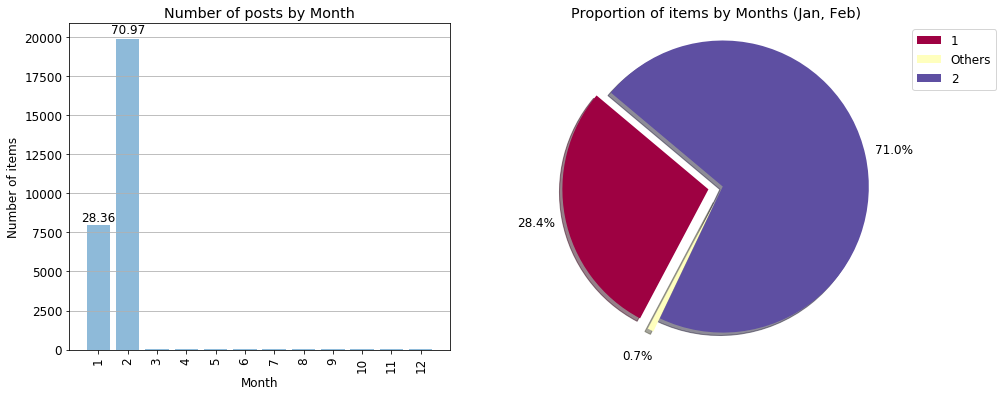

In [30]:
#define figures
plt.figure(figsize=(15,6))

# Plot number of post by month
plt.subplot(121);
plot_histogram(df['Month'], sort=True)

# Plot the proportion of posts in January and February
plt.subplot(122);
plot_pie_chart(df.apply(
    lambda row: row.Month if row.Month in [1,2] else 'Others', axis=1).rename('Months (Jan, Feb)'))
plt.show();

From the histogram above, representing the number of posts by Month, we observe that some few posts are **misclassified**, they don't belong neither to **January** nor to ** February**. Since they are negligible, (only 0.7% from the pie chart), and we are focusing in comparing these two dates only, we decieded to drop them for this **Milestone**.

It would also be interesting to observe how the post are **distributed by language**. Moreover, we want to analyse how types of posts are distributted as well. We plot the language and post type distributions in the following:

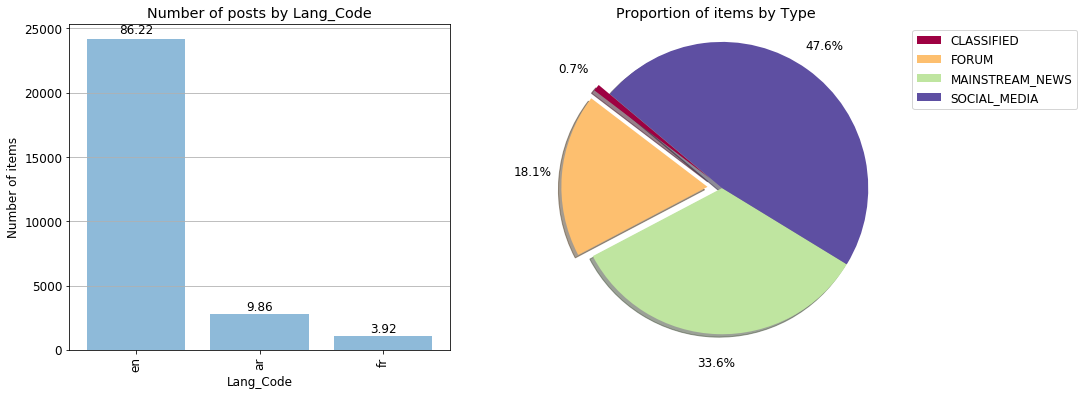

In [31]:
def plot_type_lang(df=df):
    """
    plots a histogram of languages and a pie chart of types
    :param df: the dataframe
    """
    plt.figure(figsize=(15,6))
    plt.subplot(122)
    plot_pie_chart(df['Type'])
    plt.subplot(121)
    plot_histogram(df['Lang_Code'])
    plt.show()

plot_type_lang();

**English** is clearly the dominant language in the dataset, with more than **86%**, followed by **Arabic (~10%)** and **French (~4%)**.

Regarding the distribution of post's types, the majority of posts comes from **SOCIA_MEDIA (47.6%)** and **MAINSTREAM_NEWS (33.6%)**. Nearly **18.1%** are **FORUM posts**.

To conclude our global analysis, we define the following function to plot the distribution of the **keyphrases score** for oul filtered data:

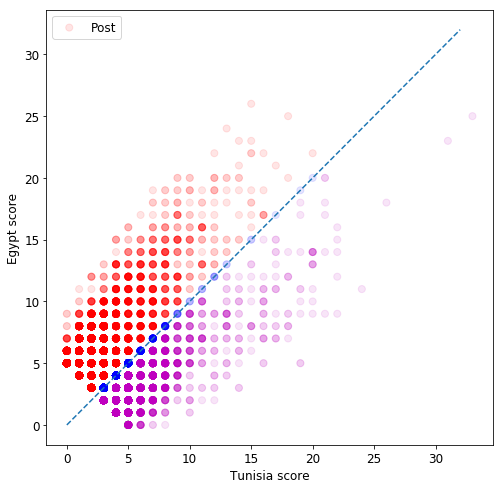

In [32]:
def tn_egy_scater(df=df):
    """
    Plots a scater plot of posts beased on Tunisia and Egypt keyword scores.
    :param df: DataFrame
    """
    plt.figure(figsize=(8,8))
    plt.scatter(df.Tunisia, df.Egypt, s=50*np.ones_like(df.Tunisia), 
                c=['m' if x>0 else 'r' if x<0 else 'b' for x in df.Tunisia-df.Egypt], 
                alpha=0.1, marker='o', label="Post")
    plt.xlabel("Tunisia score")
    plt.ylabel("Egypt score")
    plt.legend()
    x = np.arange(max(df.Tunisia))
    plt.plot(x,'--')
    plt.show()

tn_egy_scater()

## 2.6. How different are Jan. 14 and Feb. 11 in Data Distributions?<a class="anchor" id="26"></a>

We start by making a comparison between the two collected dates (14-01-2011 and 11-02-2011), since they represent two different interesting points on time. 

**14-01-2011:** [Ben Ali quits after 23 yrs in power & leaves Tunisia](https://www.alarabiya.net/articles/2011/01/14/133432.html).

**11-02-2011:** [Hosni Mubarak resigns as president](http://www.aljazeera.com/news/middleeast/2011/02/201121125158705862.html).

Having collected data from this two dates, we are now ready to start our analysis.

### 2.6.1. Language and Post Type Distributions<a class="anchor" id="261"></a>

For **Jan. 14, 2011**, the day when **Tunisia**'s President resigned:

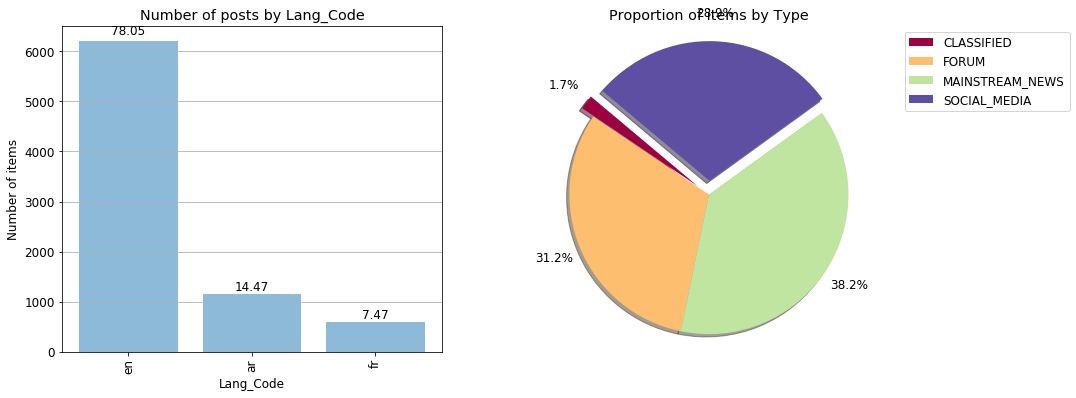

In [33]:
jan_df = df.loc[df.Month == 1]
plot_type_lang(df=jan_df)

For **Feb. 11, 2011**, the day when **Egypt**'s President resigned:

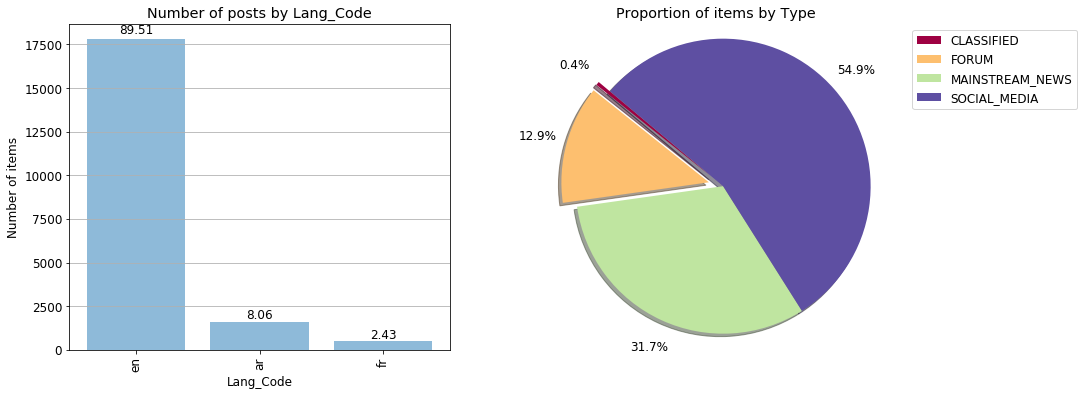

In [34]:
feb_df = df.loc[df.Month == 2]
plot_type_lang(df=feb_df)

**Observations:**

- **Post Type Distribution:** We notice that both dates contain a negligible amount of the type `CLASSIFIED`. However, whereas the distributions in `NEWS`, `SOCIAL_MEDIA` and `FORUM` are close to equal for Jan. 14, over half of the shares of posts are `SOCIAL_MEDIA` posts for Feb. 11, and there are less `FORUM` posts.

- **Language Distribution:** The distribution of languages is overall skewed to English for both, but more so for Feb. 11. Given the fact that Tunisia has a large francophone population, there is more French-language data for Jan. 14. Likewise, Egypt has a large English-speaking population, and that could explain the fact that English has a larger share in Feb. 11.

### 2.6.2. Country Distributions<a class="anchor" id="262"></a>

For **Jan. 14, 2011**, the day when **Tunisia**'s President resigned:

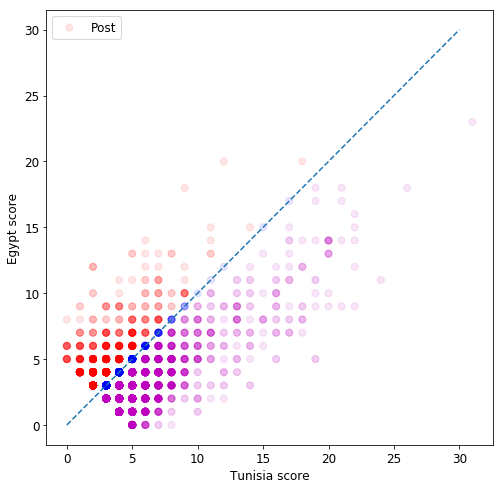

In [35]:
tn_egy_scater(df=jan_df)

For **Feb. 11, 2011**, the day when **Egypt**'s President resigned:

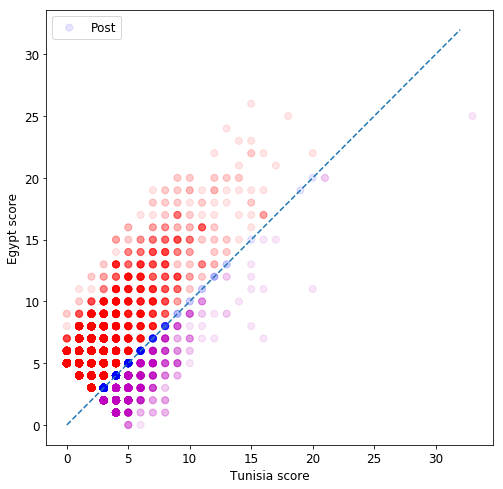

In [36]:
tn_egy_scater(feb_df)

**Observations:**

We notice that our keyphrases were effective in choosing the data, as we see that the distribution gets skewed towards the country where the presidential resignation is happening on both dates.

## 2.7. Keyword Detection by Language and Post Type<a class="anchor" id="27"></a>

To get a more insightful experience of these two months, we compare what were the **most common keywords** in each period. We will use the text data in the Post Titles, corresponding to the column `Post_Title`.

### 2.7.1. Keyword Extraction<a class="anchor" id="271"></a>

We first make the two following functions to get keywords per language and post type:

In [37]:
def get_keywords_per_language(content, language):
    """
    Gets keywords for the given content as per its corresponding language.
    :param content: string
    :param language: string
    :return: list of strings
    """
    unigram_tokens = tokenize_without_stopwords(content, language)
    keywords = get_most_popular_tokens(unigram_tokens, 50)
    return keywords

def get_keywords_per_column(column):
    """
    Gets keywords per DataFrame column.
    :param row: DataFrame column
    :return: list of lists of strings
    """
    return [get_keywords_per_language(column[multi_index], CODE_TO_LANG[multi_index[1]]) 
            for multi_index in column.index]

We put the keywords in the following `DataFrame`:

In [38]:
keywords_per_type_lang = df[(df.Month.isin([1,2])) & (df.Type != 'CLASSIFIED')].groupby(
    ['Month', 'Lang_Code', 'Type'])[['Post_Title']].agg(
    lambda texts: ' '.join(texts)).unstack().apply(get_keywords_per_column)
keywords_per_type_lang

Post_Title  \
Type                                                         FORUM   
Month Lang_Code                                                      
1     ar         [تونس, بن, علي, فى, و, الرئيس, الله, التونسي, ...   
      en         [½ï, new, tunisia, video, government, repack, ...   
      fr         [re, les, tunisie, sydney, ben, ali, janvier, ...   
2     ar         [مبارك, مصر, فى, الرئيس, التحرير, الله, الشعب,...   
      en         [mubarak, egypt, financial, analysis, online, ...   
      fr         [re, les, ligne, a, guilde, comment, site, inf...   

                                                                    \
Type                                               MAINSTREAM_NEWS   
Month Lang_Code                                                      
1     ar         [تونس, ن, علي, القذافي, جلس, الشعب, الكرسي, اح...   
      en         [tunisia, president, tunisian, government, pro...   
      fr         [ben, tunisie, ali, les, a, président, gouvern...   
2     ar         [مبارك, مصر, المصري, الرئيس, الشعب, الجيش, بيا...   
      en         [mubarak, egypt, egyptian, protesters, power, ...   
      fr         [moubarak, les, egypte, hosni, caire, manifest...   

                                                                    
Type                                                  SOCIAL_MEDIA  
Month Lang_Code                                                     
1     ar         [و, تونس, التونسي, الشعب, بن, علي, http, البلا...  
      en         [people, police, tunisia, many, power, governm...  
      fr         [les, a, tunisie, ali, ben, président, http, p...  
2     ar         [و, مبارك, الثورة, مصر, الرئيس, الشعب, http, c...  
      en         [people, mubarak, egypt, egyptian, power, pres...  
      fr         [les, moubarak, a, président, egypte, hosni, t...

### 2.7.2. Keywords on January 14<a class="anchor" id="272"></a>

The following are the keywords on Jan. 14 for `MAINSTREAM_NEWS` and `SOCIAL MEDIA` in English:

In [39]:
keywords_per_type_lang.loc[(1, 'en')]['Post_Title']['MAINSTREAM_NEWS'][:10]

['tunisia',
 'president',
 'tunisian',
 'government',
 'protests',
 'new',
 'police',
 'ali',
 'ben',
 'power']

In [40]:
keywords_per_type_lang.loc[(1, 'en')]['Post_Title']['SOCIAL_MEDIA'][:10]

['people',
 'police',
 'tunisia',
 'many',
 'power',
 'government',
 'officers',
 'president',
 'tunisian',
 'officer']

**Observation**

We see that the text data is dominated by talk about Tunisia. We notice less formality in Social Media, as there is talk about *people* rather than *protesters*. But overall, there is a consistency in the keywords.

### 2.7.3. Keywords on February 11<a class="anchor" id="273"></a>

The following are the keywords on Jan. 14 for `MAINSTREAM_NEWS` and `SOCIAL MEDIA` in English:

In [41]:
keywords_per_type_lang.loc[(2, 'en')]['Post_Title']['MAINSTREAM_NEWS'][:10]

['mubarak',
 'egypt',
 'egyptian',
 'protesters',
 'power',
 'president',
 'obama',
 'military',
 'hosni',
 'protests']

In [42]:
keywords_per_type_lang.loc[(2, 'en')]['Post_Title']['SOCIAL_MEDIA'][:10]

['people',
 'mubarak',
 'egypt',
 'egyptian',
 'power',
 'president',
 'hosni',
 'government',
 'military',
 'revolution']

**Observation**

Here, the dominant topic is Egypt. We notice the same phenomenon about formality across post types, and keywords remain consistent.

# 5. Topic Detection<a class="anchor" id="51"></a>

To follow on with the analysis, topic detection represents a more meaningful source of data, because of the information we can pick from the `latent features`.<br> 
-We start by defining the number of topics that we want to apply when clustering our data.<br>
-After clustering, we can infer the thematic associated with a specific topic by **evaluating the words that influence that topic the most**.<br>

## 5.1) Preprocessing Data for topic detection

### 5.1.1) Tokenize posts by language and country

We start by defining a function that **tokenizes (without stop words) every post content for a specified country and language**:

In [43]:
import string

def post_content_collector(df, language, filterbyCountry = False, country = None):
    """
    Collects content from df, according to specified
    language and country(optinal)
    :param df: DataFrame
    :param language: String w/ language
    :param filterbyCountry: Boolean
    :param contry: country to filter
    :return posts: list of posts (tokenized)
    """
    if filterbyCountry == True:
        #filter by country
        if country == EG:
            df_filter = df_filter[(df.Egypt > df.Tunisia)]
        else:
            df_filter = df_filter[(df.Tunisia > df.Egypt)]
    #filter by language
    df_filter = df[(df.Lang_Code == language[:2])]
    
    posts = [tokenize_without_stopwords(str(row[1]['Post_Content']),language) for row in df_filter.iterrows()]
    return posts

In [44]:
posts = post_content_collector(df,EN)
len(posts)

24163

### 5.2.2) Add bigrams to posts tokenized content

Keeping in mind the topics such be as clear as possible, **add some bigrams** to get more **meaningful keywords for each topic**:

In [45]:
def include_bigrams(min_count):
    """
    Add bigrams to posts content
    :param min_count: int - minimium values of count in
                    order to be incuded as bigram
    """
    from gensim.models.phrases import Phrases
    # Add bigrams to posts
    bigram = Phrases(posts, min_count)
    for idx in range(len(posts)):
        for token in bigram[posts[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                posts[idx].append(token)

In [46]:
# define min count to be considered as bigram
min_count = 15
include_bigrams(min_count)

### 5.3.3) Buid Bag of Words representation

Each `posts[i]` contains the corresponding tokanized version. We are now in the conditions to build a `Bag of Words` representation, for every post:

In [47]:
from gensim import corpora
import gensim.models

def BOW(max_freq, min_wordcount):
    """
    Creates a dictionary and BOW representation using gensim library
    :param max_freq: int - do not consider too frequent words
    :param min_wordcout: int - minimium number of word counts to be considered
    :return corpus
    :return posts 
    """
    dictionary = corpora.Dictionary(posts)
    # filter dictionary
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
    corpus = [dictionary.doc2bow(post) for post in posts]
    corpus = [post for post in corpus if len(post)>0] # filter out empty sentences
   
    return corpus, dictionary

In [48]:
max_freq = 0.5
min_wordcount = 5
corpus, dictionary = BOW(max_freq, min_wordcount)

### 5.4.4) Apply Topic Extraction Tecnhiques

Having finished collecting and pre-processing the data, we are ready to follow on with the topic detection approach.<br> There are several melthods in the field of `topic extraction`, and its performance varies along with the datasets where the algorithm is being applied on. With this idea on mind, we will run **two different techniques to estimate topics**:

1: `LSA` - Latent Semantic Analysis<br>
2: `LDA` - Latent Dirichlet Allocation

**1. LSA Model**:

From the `BOW` representation we follow on with the `matrix factorization`. For this purpose, we use the `tf-idf` model from `gensim` library: 

In [49]:
# Define number of topics to divide our data
n_topics = 3

# apply model:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
model = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=n_topics)

In [50]:
def show_topWords_topics(n_topics,n_words):
    """
    Displays most influent words per topic
    :param max_freq: int 
    :param min_wordcout: int 
    """
    for topic_i in range(n_topics):
        print(model.show_topic(topic_i, n_words),'\n')
              
show_topWords_topics(3,5)

[('mubarak', 0.24954269699530732), ('president', 0.23390033185052306), ('egypt', 0.20011867282183909), ('hosni', 0.19091483919042843), ('egyptian', 0.19063457794175712)] 

[('hosni', -0.21030346073566095), ('president', -0.19532583331882367), ('hosni_mubarak', -0.19528331806710761), ('mubarak', -0.18770929197079225), ('egyptian_president', -0.15076232769321765)] 

[('ali', -0.37347763726862848), ('ben', -0.37174776912989588), ('ben_ali', -0.31108128419121811), ('tunisia', -0.25521208242316734), ('zine', -0.24501044262322652)] 



By analising the most influent worlds for each topic we can infer its matter.

**Plot Results:**

Let's see how are post are distributed in n-topic Dimension:

In [51]:
def create_3Dtopic_vectors():
    """
    Creates 3D vectors of the post's distribution over different topics
    """
    # create vectors on 3-D Space:
    which_posts = np.arange(0, 1000, 1)
    x = []
    y = []
    z = []

    for w in which_posts:
        # append topic distribution for each post
        x.append(model[corpus_tfidf][w][0][1])
        y.append(model[corpus_tfidf][w][1][1])
        z.append(model[corpus_tfidf][w][2][1])
    return np.array(x), np.array(y), np.array(z)

In [52]:
import plotly.plotly as py
import plotly.graph_objs as go

topic1, topic2, topic3 = create_3Dtopic_vectors()

trace = go.Scatter3d(x = topic1, y = topic2, z = topic3, mode = 'markers')
data = [trace]
py.iplot(data)

**2. LDA Model**

Latent Dirichlet Allocation is one of the main techniques to estimate topics. <br>It assumes that **each posts comes from a distribution of topics**. Moreover, every **topic is in turn a distrubition probability over words** in the vocabulary

In [56]:
# models
from gensim.models import LdaModel
from numpy.random import seed as random_seed
seed = 43
np.seterr(invalid='warn')

params = {'passes': 10, 'random_state': seed}
base_models = dict()
model_Lda = LdaModel(corpus=corpus, num_topics=4, id2word=dictionary,
                passes=params['passes'], random_state=params['random_state'])

In [57]:
model_Lda.show_topics(num_words=5)

[(0,
  '0.007*"people" + 0.007*"one" + 0.006*"like" + 0.005*"many" + 0.005*"time"'),
 (1,
  '0.006*"said" + 0.006*"government" + 0.004*"new" + 0.004*"would" + 0.003*"also"'),
 (2,
  '0.019*"http" + 0.019*"com" + 0.017*"type" + 0.017*"www" + 0.015*"http_www"'),
 (3,
  '0.028*"mubarak" + 0.026*"egypt" + 0.021*"people" + 0.020*"president" + 0.019*"egyptian"')]

In [60]:
import pyLDAvis.gensim

# plot topics
data =  pyLDAvis.gensim.prepare(model_Lda, corpus, dictionary)
pyLDAvis.display(data)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



# 3. Future Directions<a class="anchor" id="3"></a>

Now that we have enriched and filtered our data using Wikipedia, and pre-processed it and got first results, we got a clearer idea of our next steps:

1. **Filtering the entire 2.1TB of compressed data.** Our sample was about 40GB of compressed data, and we have filtered it to about 170MB. Given that our sample covered 2 days, we estimate our entire filtered dataset to be about 5GB. Our next step is therefore to filter the entire dataset on the cluster and handle the data locally.
2. **Separating the data by country.** There are many ways we can do it, we can use keyphrases that are not in the intersection of the keyphrases of Egypt and Tunisia to get specific articles, or we can allocate a post to the country for which it has the highest keyphrase score.
3. **Topic Extraction.** We noticed in our keywords in subsection 2.7 that some of them are in our keyphrases extracted from Wikipedia. TF-IDF measures can help get specific keyphrases, and get us closer to extracting popular expressions of concerns and demands. We also plan to use again n-grams and the content of posts in addition to titles, and to use Latent Dirichlet Allocation (LDA) to extract topics.
4. **Time Series Analysis.** After having extracted the topics, we want to see their evolution over time. For example, is a given topic more ephemeral than central to the revolutions? Our primary time unit for analysis is days.